In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns
import itertools as iter

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['orders.csv', 'departments.csv', 'products.csv', 'sample_submission.csv', 'order_products__train.csv', 'order_products__prior.csv', 'aisles.csv']


In [2]:
products = pd.read_csv('../input/products.csv')
aisles = pd.read_csv('../input/aisles.csv')
departments = pd.read_csv('../input/departments.csv')
order_products_train = pd.read_csv('../input/order_products__train.csv')
order_products_prior = pd.read_csv('../input/order_products__prior.csv')
orders = pd.read_csv('../input/orders.csv')

In [3]:
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left', on = 'department_id'), right=aisles, how='left', on = 'aisle_id')
Train_data = orders.merge(order_products_prior,how='inner', left_on='order_id', right_on='order_id').drop(columns=['eval_set'])

In [4]:
Train_data = Train_data.merge(items,how='inner', left_on='product_id', right_on='product_id')

In [5]:
Train_data.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2539329,1,1,2,8,NaN,196,1,0,Soda,77,7,beverages,soft drinks
1,2398795,1,2,3,7,15.0,196,1,1,Soda,77,7,beverages,soft drinks
2,473747,1,3,3,12,21.0,196,1,1,Soda,77,7,beverages,soft drinks
3,2254736,1,4,4,7,29.0,196,1,1,Soda,77,7,beverages,soft drinks
4,431534,1,5,4,15,28.0,196,1,1,Soda,77,7,beverages,soft drinks


In [6]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

**MISSING DATA**

In [7]:
total = Train_data.isnull().sum().sort_values(ascending=False)
total
percent = (Train_data.isnull().sum()/Train_data.isnull().count()).sort_values(ascending=False)
percent
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
days_since_prior_order,2078068,0.06407
aisle,0,0.00000
department,0,0.00000
department_id,0,0.00000
aisle_id,0,0.00000
product_name,0,0.00000
reordered,0,0.00000
add_to_cart_order,0,0.00000
product_id,0,0.00000
order_hour_of_day,0,0.00000


**MOST ORDERED PRODUCTS**

In [40]:
prod_f = order_products_all.groupby("product_id")["reordered"].size().reset_index(name='Total_reorders')
prod_f = pd.merge(prod_f, products[['product_id', 'product_name']], how='left', on=['product_id'])
prod_f = prod_f.sort_values(by='Total_reorders', ascending=False)[:10]
prod_f

,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


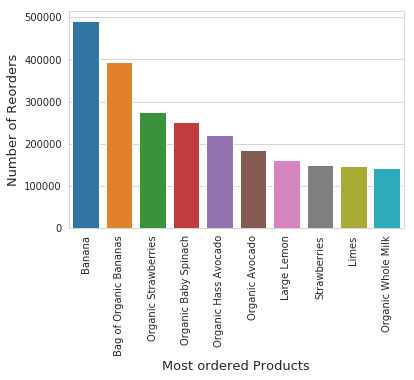

In [41]:
prod_f  = prod_f.groupby(['product_name']).sum()['Total_reorders'].sort_values(ascending=False)

sns.set_style('whitegrid')
plt.xticks(rotation='vertical')
sns.barplot(prod_f.index, prod_f.values)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()

**Most reordered products**

In [42]:
prod_f = order_products_all.groupby("product_id")["reordered"].agg({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
prod_f['reorder_probability'] = prod_f['reorder_sum'] / prod_f['reorder_total']
prod_f = pd.merge(prod_f, products[['product_id', 'product_name']], how='left', on=['product_id'])
prod_f = prod_f[prod_f.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
prod_f

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.933333,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.921569,Chocolate Love Bar
35601,35604,93,104,0.894231,Maca Buttercups
38248,38251,99,111,0.891892,Benchbreak Chardonnay
36798,36801,88,99,0.888889,Organic Blueberry B Mega
10233,10236,114,131,0.870229,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868421,Thousand Island Salad Snax
5455,5457,78,90,0.866667,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862144,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861436,Half And Half Ultra Pasteurized


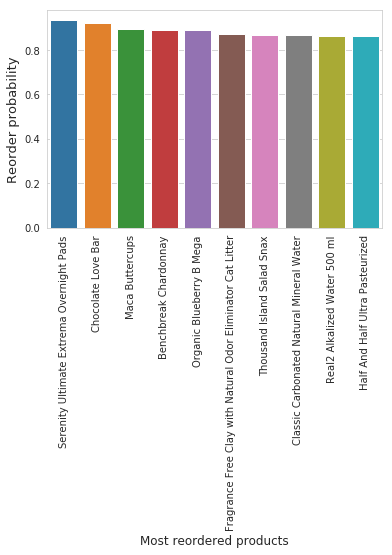

In [43]:
prod_f  = prod_f.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)

sns.set_style('whitegrid')
#f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(prod_f.index, prod_f.values)
#plt.ylim([0.85,0.95])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=12)
plt.show()


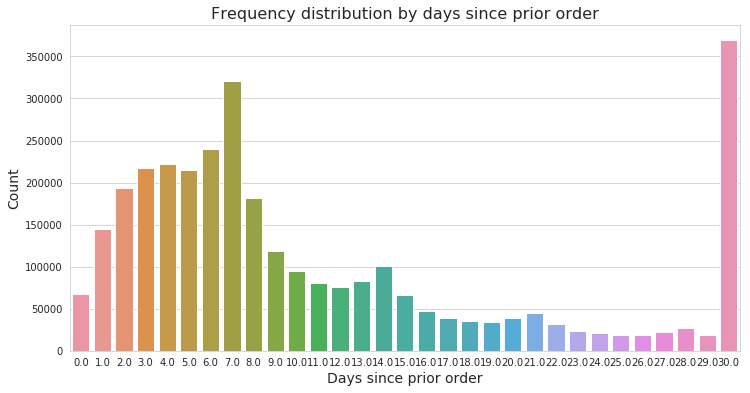

In [44]:
plt.figure(figsize=(12,6))
sns.set_style('whitegrid')
sns.countplot(x="days_since_prior_order", data=orders)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Days since prior order', fontsize=14)
plt.title("Frequency distribution by days since prior order", fontsize=16)
plt.show()

From this plot we can see that 7th day is where we have a spike, and then a relative small peak at days 14,21 and 28 which indicates that every 7 days or weekly is the order frequency. And then again there's a huge peak at the end of the month indicating that there's a monthly peak.

In [47]:
deptIsle= items.groupby(['department_id','department','aisle']).size().reset_index(name='Total_products')
deptIsle.nlargest(10, 'Total_products')


,department_id,department,aisle,Total_products
133,21,missing,missing,1258
117,19,snacks,candy chocolate,1246
10,1,frozen,ice cream ice,1091
64,11,personal care,vitamins supplements,1038
102,16,dairy eggs,yogurt,1026
118,19,snacks,chips pretzels,989
37,7,beverages,tea,894
98,16,dairy eggs,packaged cheese,891
5,1,frozen,frozen meals,880
119,19,snacks,cookies cakes,874


**PRODUCTS BY DEPARTMENT**

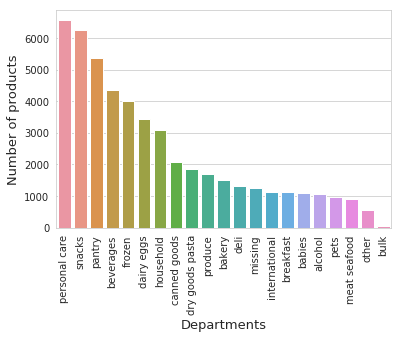

In [48]:

deptIsle= items.groupby(['department']).size().reset_index(name='Total_products')
deptData  = deptIsle.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
#f, ax = plt.subplots(figsize=(8, 8))
plt.xticks(rotation='vertical')
sns.barplot(deptData.index, deptData.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

**PRODUCTS BY AISLE**

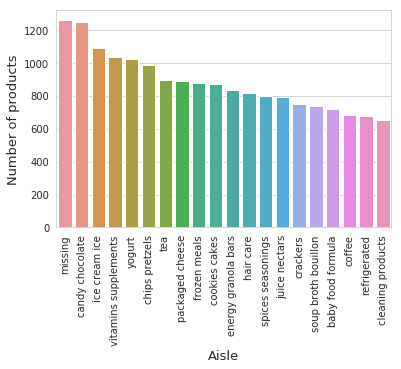

In [49]:

deptIsle= items.groupby(['aisle']).size().reset_index(name='Total_products')
aisleData  = deptIsle.groupby(['aisle']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
plt.xticks(rotation='vertical')
sns.barplot(aisleData.index[0:20], aisleData.values[0:20])
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Aisle', fontsize=13)
plt.show()

**ORDERS BY DEPARTMENT**

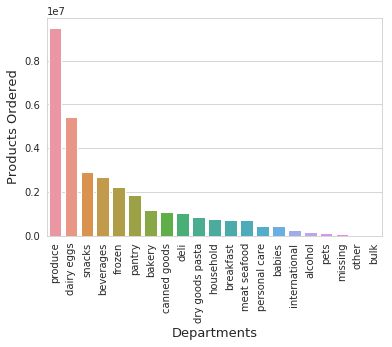

In [50]:

deptIsle= Train_data.groupby(['department']).size().reset_index(name='Total_products')
deptData  = deptIsle.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)
sns.set_style('whitegrid')
plt.xticks(rotation='vertical')
sns.barplot(deptData.index, deptData.values)
plt.ylabel('Products Ordered', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()


**ORDERS BY AISLE**

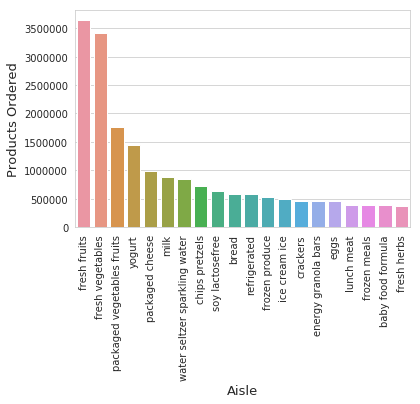

In [51]:

deptIsle= Train_data.groupby(['aisle']).size().reset_index(name='Total_products')
aisleData  = deptIsle.groupby(['aisle']).sum()['Total_products'].sort_values(ascending=False)
sns.set_style('whitegrid')
plt.xticks(rotation='vertical')
sns.barplot(aisleData.index[0:20], aisleData.values[0:20])
plt.ylabel('Products Ordered', fontsize=13)
plt.xlabel('Aisle', fontsize=13)
plt.show()

In [52]:
#17)	aisle and cart order frequency  
#here i check the order in wich the product was ordered

addToCartNumber= Train_data.groupby(['add_to_cart_order','product_name']).size().reset_index(name='Total_products')
addToCartNumber['ProdTimesAddto'] = addToCartNumber.add_to_cart_order*addToCartNumber.Total_products
addToCartNumber=addToCartNumber.groupby(['product_name']).median()['add_to_cart_order'].sort_values(ascending=True).reset_index()

addToCartNumber.head(10)

,product_name,add_to_cart_order
0,Pappardelle Nests Pasta,1.0
1,"Flax Oil, Organic, Omega-3, Original Formula",1.0
2,Rosa Mosqueta Rose Hip Seed Oil,1.0
3,Prenatal Nutrients,1.0
4,Indian Wells Merlot,1.0
5,Lndbrg White Quinoa 16 Z,1.0
6,"Indoor & Outdoor Allergies, Allergy & Congesti...",1.0
7,Chocolate Peppermint Tart,1.0
8,Easter Basket,1.0
9,Vanilla Flavor Multi-Symptom Relief,1.0


In [53]:
Reorder_rate=Train_data[['user_id','product_name', 'reordered',]].groupby(['user_id','product_name']).agg('sum')
Reorder_rate.sort_values(['user_id', 'reordered'], ascending=[True, False])

reordered
user_id product_name                                                 
1       Original Beef Jerky                                         9
        Soda                                                        9
        Pistachios                                                  8
        Organic String Cheese                                       7
        Cinnamon Toast Crunch                                       2
        Zero Calorie Cola                                           2
        Aged White Cheddar Popcorn                                  1
        Bag of Organic Bananas                                      1
        Organic Half & Half                                         1
        XL Pick-A-Size Paper Towel Rolls                            1
        0% Greek Strained Yogurt                                    0
        Bartlett Pears                                              0
        Creamy Almond Butter                                        0
        Honeycrisp Apples                                           0
        Milk Chocolate Almonds                                      0
        Organic Fuji Apples                                         0
        Organic Unsweetened Almond Milk                             0
        Organic Unsweetened Vanilla Almond Milk                     0
2       Chipotle Beef & Pork Realstick                              8
        Organic Hass Avocado                                        7
        Banana                                                      6
        Cherry Pomegranate Greek Yogurt                             5
        Fat Free Blueberry Yogurt                                   5
        Total 2% All Natural Greek Strained Yogurt with...          5
        Baked Organic Sea Salt Crunchy Pea Snack                    4
        Plantain Chips                                              4
        Total 2% with Strawberry Lowfat Greek Strained ...          4
        Hommus Classic Original                                     3
        Organic Avocado                                             3
        Pita Chips, Simply Naked, Party Size                        3
...                                                               ...
206209  Disinfecting Wipes Fresh Scent                              0
        Elbow Macaroni Pasta                                        0
        Freezer Slider Bags                                         0
        Fresh Cut Golden Sweet Whole Kernel Corn                    0
        Ground Chicken Breast                                       0
        High Protein Bar Chunky Peanut Butter                       0
        Icelandic Style Fat Free Plain Yogurt                       0
        Light Multi-Grain English Muffins                           0
        Limes                                                       0
        Organic 1% Low Fat Milk                                     0
        Organic Diced Tomatoes                                      0
        Organic Mexican Blend Finely Shredded Cheese                0
        Organic Raw Unfiltered Apple Cider Vinegar                  0
        Original Multigrain Spoonfuls Cereal                        0
        Oven Roasted Turkey Breast                                  0
        Pure Coconut Milk                                           0
        Quick 1 Minute Oatmeal                                      0
        Raisins                                                     0
        Rice Krispies Cereal                                        0
        Roasted & Salted Shelled Pistachios                         0
        Sea Salt Flakes Original                                    0
        Sensitive Toilet Paper                                      0
        Skim Milk sharp Cheddar Cheese Singles                      0
        Sourdough Demi Baguette                                     0
        Total 0% Greek Yogurt                                       0


**Frequency of Reorders in a Week**

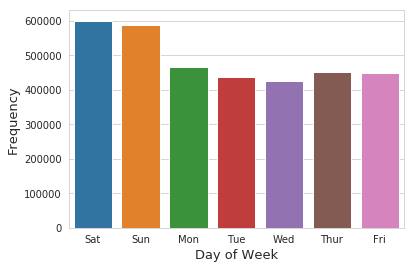

In [54]:
reorder_dow_freq = orders['order_dow'].value_counts().sort_index()
reorder_dow_freq.index=['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri']

sns.set_style('whitegrid')
sns.barplot(reorder_dow_freq.index, reorder_dow_freq.values)
plt.xlabel('Day of Week', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.show()

**Frequency of Reorders in Hour of Day**

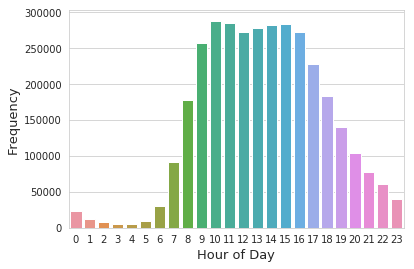

In [55]:
reorder_hour_of_day_freq = orders['order_hour_of_day'].value_counts().sort_index()
#reorder_hour_of_day_freq.index = [str(i) for i in range(24)]

sns.set_style('whitegrid')
sns.barplot(reorder_hour_of_day_freq.index, reorder_hour_of_day_freq.values)
plt.xlabel('Hour of Day', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.show()


**Nmber of Products per Order**

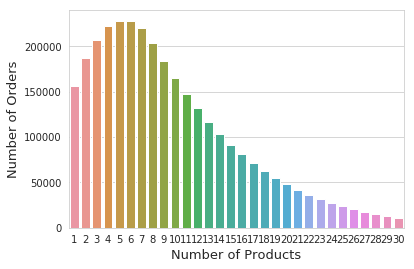

In [56]:
order_nproduct = Train_data.groupby('order_id')['product_id'].agg('count').reset_index()
order_nproduct =  order_nproduct.groupby('product_id')['order_id'].agg('count').nlargest(30)

sns.set_style('whitegrid')
sns.barplot(order_nproduct.index, order_nproduct.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of Products', fontsize=13)
plt.show()


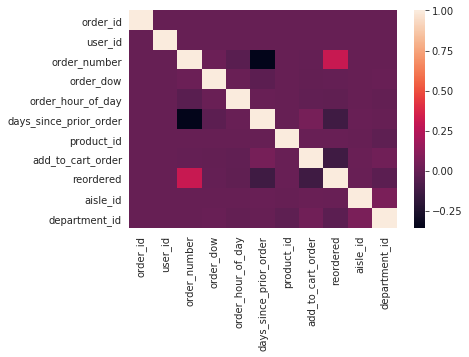

In [23]:
corr = Train_data.corr()
sns.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns)